# Statistical Analysis
This notebook aims to explore the dataset through probability and statistical methods. The goal is to describe the data, assess relationships between variables, and draw inferences using descriptive statistics, hypothesis testing, regression analysis, and residual diagnostics.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
from sleep_health.config import DATA_DIR

## 1. Descriptive summary

In [4]:
df = pd.read_csv(DATA_DIR / 'processed' / 'processed_data.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 451
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    452 non-null    int64  
 1   Age                   452 non-null    int64  
 2   Sleep duration        452 non-null    float64
 3   Sleep efficiency      452 non-null    float64
 4   Caffeine consumption  452 non-null    float64
 5   Alcohol consumption   452 non-null    float64
 6   Exercise frequency    452 non-null    float64
 7   Bedtime_hour          452 non-null    int64  
 8   Gender_encoded        452 non-null    int64  
 9   Smoking_encoded       452 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 38.8 KB


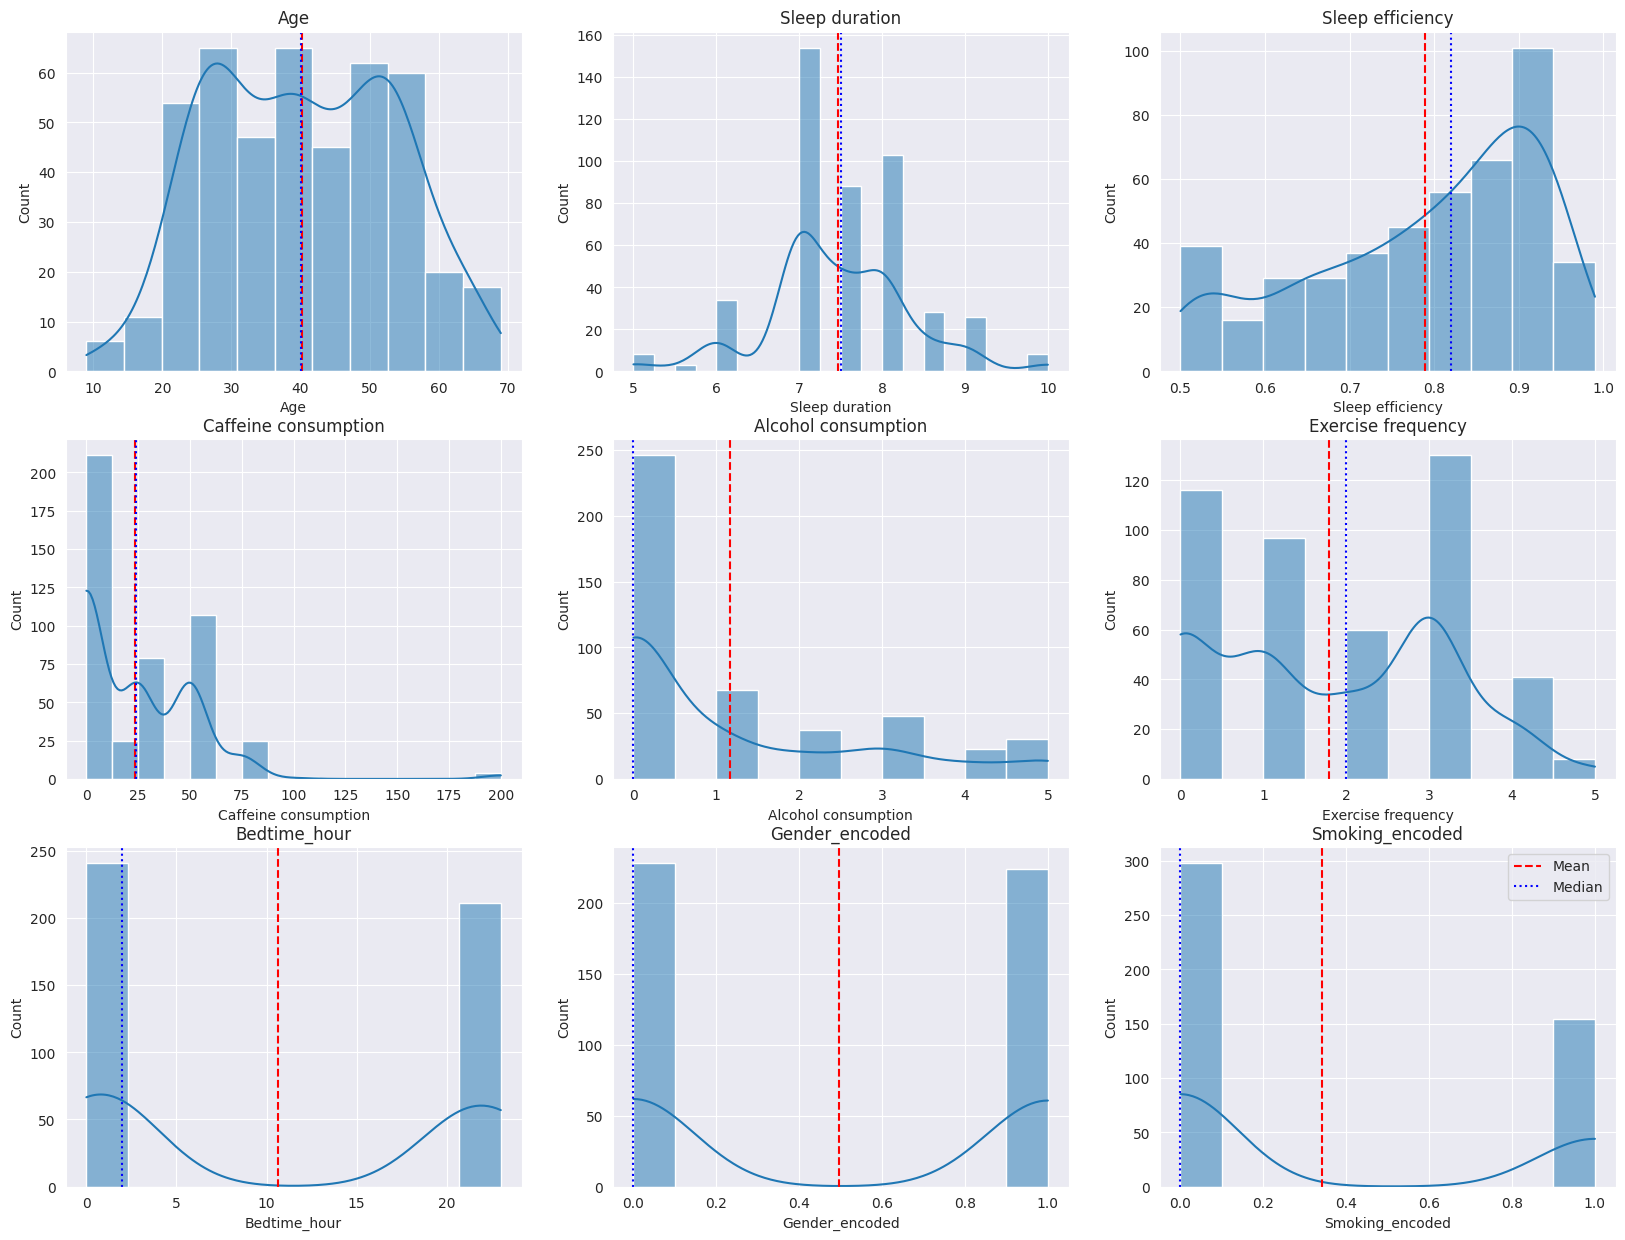

<Figure size 640x480 with 0 Axes>

In [5]:
cols = df.columns.tolist()
cols.remove('ID')

descriptive_metrics = df[cols].describe()
descriptive_metrics.drop(axis=0, index='count', inplace=True)

sns.set_style("darkgrid")
sns.color_palette("deep")

grid_cols = 3
grid_lines = len(cols) // grid_cols if len(cols) % grid_cols == 0 else (len(cols) // grid_cols) + 1

fig, axes = plt.subplots(grid_lines, grid_cols, figsize=(20, 15) )

axes_flat = axes.flatten()
for i, col in enumerate(cols):

    axes_flat[i].set_title(col)
    sns.histplot(df[col], kde=True, ax=axes_flat[i])
    axes_flat[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes_flat[i].axvline(df[col].median(), color='blue', linestyle=':', label='Median')

plt.legend()
plt.show()
plt.tight_layout()

## 2. Normality Test

We perform the normality test in order to understand which tests are more suited. 

In [6]:
from scipy.stats import shapiro

stat, p = shapiro(df['Sleep efficiency'])
print(f"Shapiro-Wilk Test for Normality:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

if p < 0.05:
    print("→ Reject the null hypothesis: Not enough confidence to affirm that the data is normally distributed.")
else:
    print("→ Fail to reject the null hypothesis: the data is probably normally distributed.")


Shapiro-Wilk Test for Normality:
Statistic = 0.9170, p-value = 0.0000
→ Reject the null hypothesis: Not enough confidence to affirm that the data is normally distributed.


The data does not show enough evidence for us to assume that SleepEfficiency is normally distributed. Thus, we will run non-parametric tests.

## 3. Hypothesis Testing

As the dependent variable (Sleep efficiency) is not normally distributed we will need to use:
- Mann-Whitney U: for variables with 2 groups
- Kruskal-Wallis: for variables with more than 2 groups

We divided each variable into groups in order to understand the data better and to perform the tests
Groups:
- Age: I would like to separate the groups into children/adolescents adults and elder people, but the children groups were going to be too small. So I chose to separate them into children/adults and elders
    - Juvenile: X < 25
    - Adults: 25 < X < 45
    - Elders 45 < X
- Sleep duration:
    - Not enough sleep: X < 7
    - Enough sleep: 7 < X < 8
    - Too much sleep: 8 < X

- Caffeine Consumption
    - Non consumers
    - Consumes at max 30mg
    - Consumes more than 30mg

- Alcohol Consumption
    - Non consumers
    - Consumers

- Exercise frequency
    - Do not exrceise
    - Exercise at most 2 days
    - Exercise more than 2 days

- Bedtime hour
    - Sleep untill 23pm
    - Sleep after 23pm

- Gender
    - Male
    - Female

- Smokers
    - Smokers
    - Non-smokers

In [7]:
group_masks = {
    "Age": {
        "Juvenile": df["Age"] < 25,
        "Adults": (df["Age"] >= 25) & (df["Age"] <= 45),
        "Elders": df["Age"] > 45
    },
    "Sleep duration": {
        "Not enough sleep": df["Sleep duration"] < 7,
        "Enough sleep": (df["Sleep duration"] >= 7) & (df["Sleep duration"] <= 8),
        "Too much sleep": df["Sleep duration"] > 8
    },
    "Caffeine consumption": {
        "Non consumers": df["Caffeine consumption"] == 0,
        "Consumes at most 30mg": (df["Caffeine consumption"] > 0) & (df["Caffeine consumption"] <= 30),
        "Consumes more than 30mg": df["Caffeine consumption"] > 30
    },
    "Alcohol consumption": {
        "Non consumers": df["Alcohol consumption"] == 0,
        "Consumers": df["Alcohol consumption"] > 0
    },
    "Exercise frequency": {
        "Do not exercise": df["Exercise frequency"] == 0,
        "Exercise at most 2 days": (df["Exercise frequency"] > 0) & (df["Exercise frequency"] <= 2),
        "Exercise more than 2 days": df["Exercise frequency"] > 2
    },
    "Bedtime hour": {
        "Sleep until 23pm": (df["Bedtime_hour"] >= 18) & (df["Bedtime_hour"] < 23),
        "Sleep after 23pm": (df["Bedtime_hour"] >= 23) | (df["Bedtime_hour"] < 3)
    },
    "Gender": {
        "Male": df["Gender_encoded"] == 1,
        "Female": df["Gender_encoded"] == 0
    },
    "Smokers": {
        "Smokers": df["Smoking_encoded"] == 1,
        "Non smokers": df["Smoking_encoded"] == 0
    }
}


We can perform the tests for each variable. If the variable has more than 2 groups we will use the Kruskal and Mann-Whitney for the variables with 2 groups.

In [8]:
from scipy.stats import mannwhitneyu, kruskal

results = {}

for group_name, group_dict in group_masks.items():
    masks = list(group_dict.values())
    labels = list(group_dict.keys())

    group_data = [df[mask]["Sleep efficiency"] for mask in masks]


    if len(group_data) == 2:
        stat, p = mannwhitneyu(group_data[0], group_data[1], alternative='two-sided')
        results[group_name] = {
            "test": "Mann-Whitney U",
            "p_value": p,
            "significant": p < 0.05
        }
    else:
        stat, p = kruskal(*group_data)
        results[group_name] = {
            "test": "Kruskal-Wallis",
            "p_value": p,
            "significant": p < 0.05
        }


/tmp/ipykernel_4663/2244123825.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pvals.applymap(lambda x: f"{x:.5f}"),


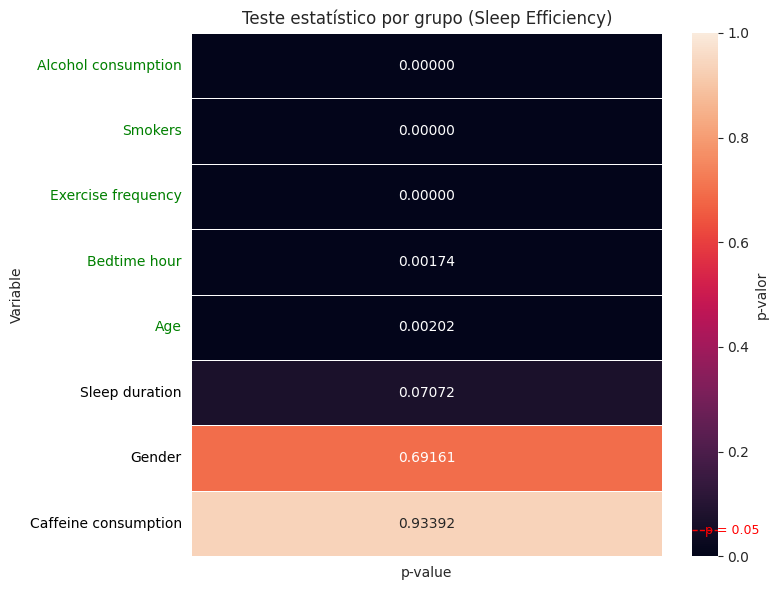

In [9]:
results_df = pd.DataFrame([
    {"Variable": k, "Test": v["test"], "p-value": v["p_value"], "Significant": v["significant"]}
    for k, v in results.items()
])

results_df = results_df.sort_values(by="p-value", ascending=True).set_index("Variable")
pvals = results_df[["p-value"]]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    pvals,
    annot=pvals.applymap(lambda x: f"{x:.5f}"),
    fmt='',
    linewidths=0.5,
    cbar_kws={'label': 'p-valor'},
    vmin=0, vmax=1
)

for ytick, sig in zip(ax.get_yticklabels(), results_df["Significant"]):
    ytick.set_color("green" if sig else "black")
cbar = ax.collections[0].colorbar
cbar.ax.hlines(0.05, *cbar.ax.get_xlim(), color='red', linestyle='--', linewidth=1)
cbar.ax.text(0.5, 0.05, 'p = 0.05', ha='left', va='center', color='red', fontsize=9)
plt.title("Teste estatístico por grupo (Sleep Efficiency)")
plt.tight_layout()
plt.show()


The results show strong evidence that alcohol consumption, smoking, exercise frequency, bedtime hour, and age are significantly associated with sleep efficiency, with p-values well below the 0.05 threshold.

For sleep duration, the p-value (0.07072) suggests a potential difference between groups, but it does not provide enough statistical confidence to assert a significant effect — the result is close to the threshold but still above it.

In contrast, the tests indicate that gender (p = 0.69161) and caffeine consumption (p = 0.93392) are most likely not associated with variations in sleep efficiency, as the high p-values suggest no meaningful difference between the groups. This outcome is somewhat surprising, but it aligns with the correlation matrix findings from the EDA notebook.

## 4. Regressions

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

First of all, we need to take into account the cyclical nature of the hours of the day. Therefore, we use the sine and cosine of the hour to represent it appropriately. This strategy will bring the 23h close to 00h

In [11]:
df["bedtime_sin"] = np.sin(2 * np.pi * df["Bedtime_hour"] / 24)
df["bedtime_cos"] = np.cos(2 * np.pi * df["Bedtime_hour"] / 24)

In [12]:
cols = df.drop("ID", axis=1).columns
standard_df = pd.DataFrame(StandardScaler().fit_transform(df[cols]), columns=cols)
standard_df.head()

,Age,Sleep duration,Sleep efficiency,Caffeine consumption,Alcohol consumption,Exercise frequency,Bedtime_hour,Gender_encoded,Smoking_encoded,bedtime_sin,bedtime_cos
0,1.878342,-1.693157,0.674260,-0.807349,-0.732593,0.850779,-0.914906,1.008889,1.391066,0.957017,0.660264
1,2.182347,-0.537977,-0.954315,-0.807349,1.148839,0.850779,-0.820210,-0.991189,1.391066,1.553179,-0.339173
2,-0.021691,0.617204,0.748286,-0.807349,-0.732593,0.850779,0.979014,1.008889,-0.718873,-1.430606,-1.929049
3,-0.021691,-1.693157,-2.064707,0.897893,2.403128,-0.560421,-0.820210,1.008889,1.391066,1.553179,-0.339173
4,1.270331,0.617204,-0.214054,-0.807349,1.148839,0.850779,-0.914906,-0.991189,-0.718873,0.957017,0.660264


Here, we use StandardScaler to standardize our values, allowing us to compare the coefficients later.

In [13]:
all_variables_list = standard_df.columns.tolist()
all_variables_list.remove("Sleep efficiency")
all_variables_list.remove("Bedtime_hour")
selected_variables = ["Age", "Alcohol consumption", "Exercise frequency", "bedtime_sin", "bedtime_cos", "Smoking_encoded"]
columns_dict = {
    "all_variables": all_variables_list,
    "selected_variables": selected_variables
}
x_train, x_test, y_train, y_test = train_test_split(standard_df[all_variables_list], standard_df["Sleep efficiency"], test_size=0.33, random_state=42)

data_dict = {}
for name, columns in columns_dict.items():
    data_dict[name] = {
        "x_train": x_train[columns],
        "x_test": x_test[columns],
        "y_train": y_train,
        "y_test": y_test,
    } 

model_dict = {}
for model_name, data in data_dict.items():
    model_dict[model_name] = LinearRegression().fit(data["x_train"], data["y_train"])


We opted to build 2 models:
1. all_variables: Uses all the variables in the dataset
2. selected_variables: Uses only the variables which the statistical tests showed that were associated with the target variables

In [14]:
coef_df = pd.DataFrame()

for model_name, model in model_dict.items():
    temp_df = pd.DataFrame({
        "variable": columns_dict[model_name],
        model_name: model.coef_
    })
    if coef_df.empty:
        coef_df = temp_df
    else:
        coef_df = pd.merge(coef_df, temp_df, on="variable", how="outer")

coef_df = coef_df.sort_values("variable").reset_index(drop=True)
print(coef_df)


               variable  all_variables  selected_variables
0                   Age       0.104579            0.101500
1   Alcohol consumption      -0.353876           -0.357534
2  Caffeine consumption       0.033822                 NaN
3    Exercise frequency       0.198977            0.201952
4        Gender_encoded      -0.011834                 NaN
5        Sleep duration      -0.006292                 NaN
6       Smoking_encoded      -0.209524           -0.207243
7           bedtime_cos       0.051365            0.048085
8           bedtime_sin      -0.102199           -0.099333


We observe that the coefficients of variables that did not show a strong association with Sleep efficiency are indeed very close to zero.
Additionally, the variables with the largest coefficients highlight their relationship with Sleep efficiency:

1. Age: Positive effect
2. Alcohol consumption: Negative effect
3. Exercise Frequency: Positive effect
4. Smoking: Negative effect

In [15]:
for name, model in model_dict.items():
    x_test = data_dict[name]["x_test"]
    y_test = data_dict[name]["y_test"]
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"R² ({name}): {r2:.4f}")
    print(f"RMSE ({name}): {rmse:.4f}")
    print()

R² (all_variables): 0.3372
RMSE (all_variables): 0.8488

R² (selected_variables): 0.3327
RMSE (selected_variables): 0.8517



By dropping some variables, we obtain a slightly more parsimonious model, which reinforces the idea that those variables have little to no impact on Sleep efficiency. However, neither model explains the target variable well. This may indicate that the relationship is not linear, that important predictors are missing, or that there is too much variability in the data.

## 5. Residuals Analysis

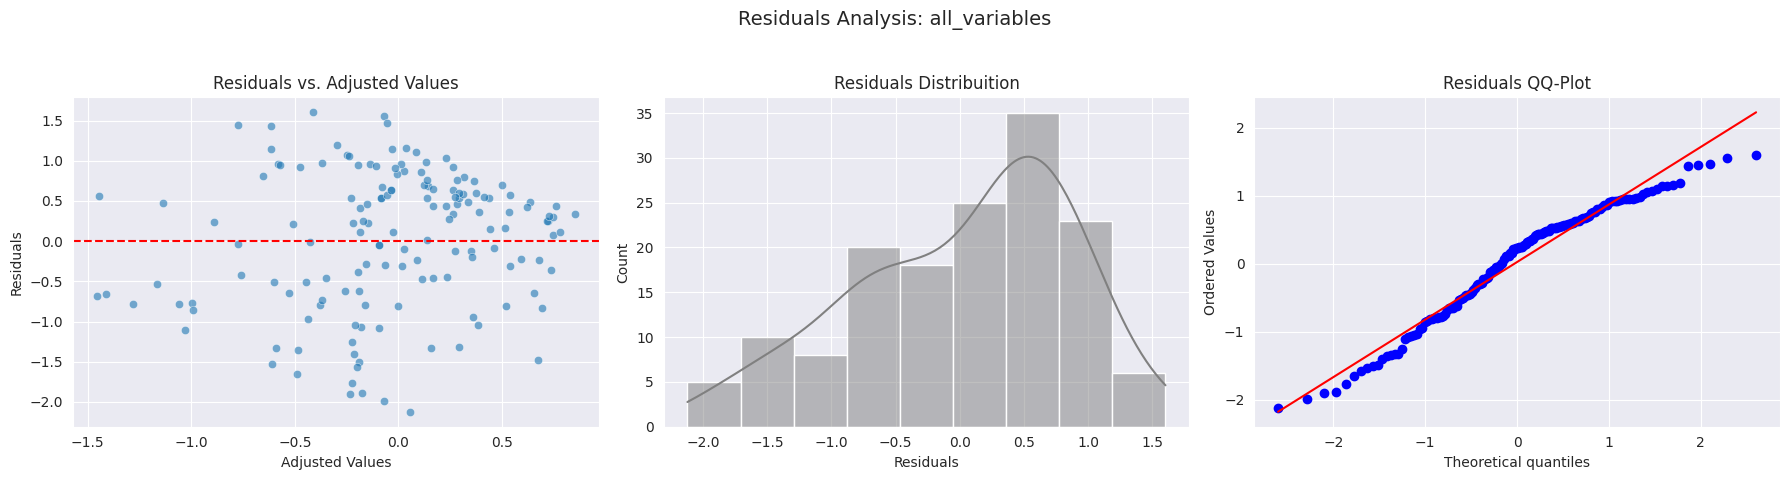

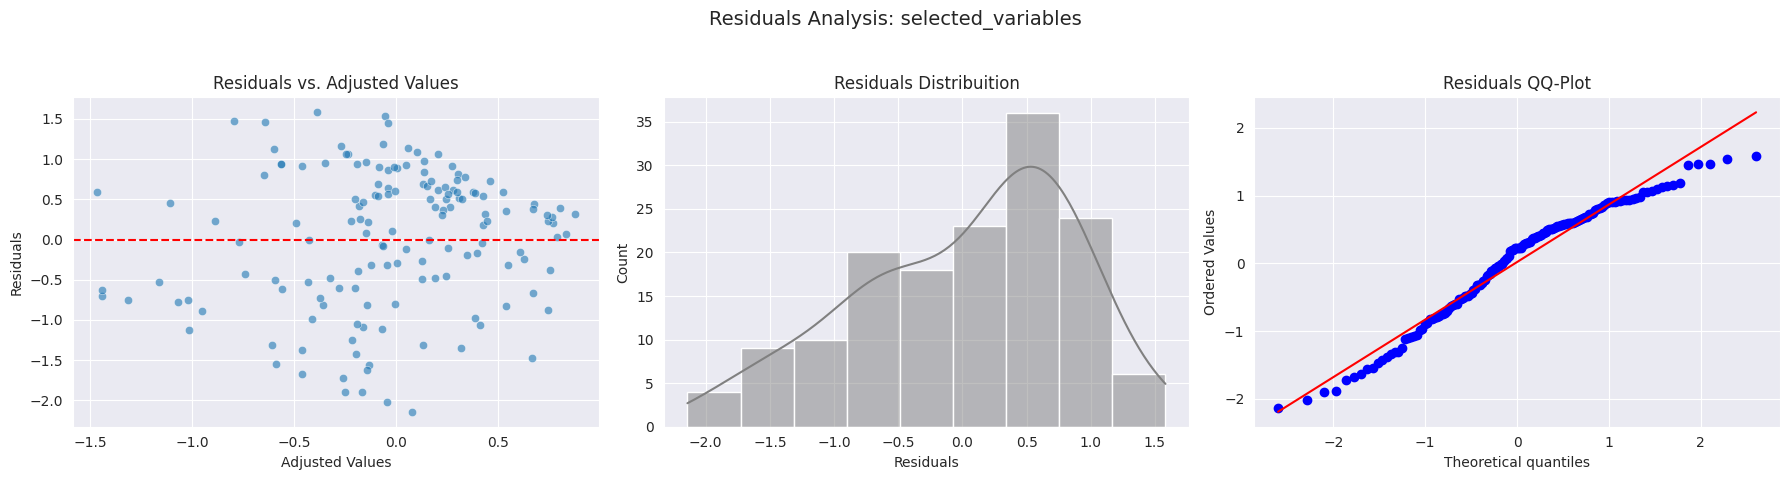

In [16]:
import scipy.stats as stats

for name, model in model_dict.items():
    y_test = data_dict[name]["y_test"]
    y_pred = model.predict(data_dict[name]["x_test"])
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Residuals Analysis: {name}", fontsize=14)

    # Residuals vs Adjusted
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0], alpha=0.6)
    axes[0].axhline(0, color="red", linestyle="--")
    axes[0].set_title("Residuals vs. Adjusted Values")
    axes[0].set_xlabel("Adjusted Values")
    axes[0].set_ylabel("Residuals")

    # KDE Histogram
    sns.histplot(residuals, kde=True, ax=axes[1], color="gray")
    axes[1].set_title("Residuals Distribuition")
    axes[1].set_xlabel("Residuals")

    # QQ-plot
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title("Residuals QQ-Plot")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


From the first chart, we observe a wide dispersion of the residuals, which is consistent with the R² and RMSE values, indicating that the models do not explain the target variable very well.
From the second chart, we can infer that the residuals likely do not follow a normal distribution, as also suggested by the QQ plot.

## 6. Multicollinearity

In [17]:
X = sm.add_constant(standard_df[all_variables_list])
vif_df = pd.DataFrame()
vif_df["variável"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


               variável       VIF
0                 const  1.000000
1                   Age  1.137567
2        Sleep duration  1.024139
3  Caffeine consumption  1.094250
4   Alcohol consumption  1.023658
5    Exercise frequency  1.210276
6        Gender_encoded  1.210056
7       Smoking_encoded  1.071633
8           bedtime_sin  1.687207
9           bedtime_cos  1.566575


The Variance Inflation Factor (VIF) analysis did not indicate issues in the set of independent variables, as all values are close to 1. This gives us confidence to rule out multicollinearity.

## 7. Results and Discussions

In this study, we analyzed how different variables influence an individual's sleep health by testing their relationship with Sleep Efficiency.

We started by rejecting the hypothesis that Sleep Efficiency follows the Normal distribuition. 

We began by rejecting the hypothesis that Sleep Efficiency follows a normal distribution.
Next, we grouped the variables and tested their association with the target. The results showed that age, bedtime, smoking, exercise frequency, and alcohol consumption are strongly associated with sleep quality, according to the data in this dataset.

We then performed linear regressions and analyzed the coefficients, leading to the following conclusions:

1. Age: Positive effect: the older the individual, the higher the Sleep Efficiency, which is somewhat surprising.
2. Alcohol consumption: Strong negative effect, the most pronounced among the variables.
3. Exercise frequency: Strong positive effect on Sleep Efficiency.
4. Smoking: Negative effect, with an intensity similar to that of exercise, but in the opposite direction.

The residuals analysis confirmed what the RMSE and R² had already indicated: the model does not perform particularly well.

Finally, the multicollinearity test revealed no issues among the independent variables, suggesting that none of them are strongly determined by a combination of the others in the set.